##Text classification with an RNN
此文本分类教程在IMDB大电影评论数据集上训练递归神经网络，以进行情感分析。

###设定

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals

import tensorflow_datasets as tfds
import tensorflow as tf

导入matplotlib并创建一个辅助函数以绘制图形：

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_graphs(history,string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string],'')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string,'val_'+string])
  plt.show()

###设置输入管道
IMDB大型电影评论数据集是一个二进制分类数据集-所有评论都具有正面或负面情绪。

使用TFDS下载数据集。

In [5]:
dataset,info = tfds.load('imdb_reviews/subwords8k',with_info=True,
                         as_supervised=True)
train_dataset,test_dataset = dataset['train'],dataset['test']

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


数据集info包括编码器（a tfds.features.text.SubwordTextEncoder）。

In [0]:
encoder = info.features['text'].encoder

In [7]:
print('Vocabulary size:{}'.format(encoder.vocab_size))

Vocabulary size:8185


该文本编码器将可逆地编码任何字符串，并在必要时退回字节编码。

In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [0]:
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print('{} ------> {}'.format(index,encoder.decode([index])))

4025 ------> Hell
222 ------> o 
6307 ------> Ten
2327 ------> sor
4043 ------> Fl
2120 ------> ow
7975 ------> .


###准备数据进行培训
接下来，创建这些编码字符串的批处理。使用该padded_batch方法将序列零填充到批处理中最长字符串的长度：

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))

test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

###创建模型
建立tf.keras.Sequential模型并从嵌入层开始。嵌入层每个单词存储一个向量。调用时，它将单词索引序列转换为向量序列。这些向量是可训练的。经过训练（在足够的数据上），具有相似含义的单词通常具有相似的向量。

这种索引查找比将单热编码矢量通过tf.keras.layers.Dense一层的等效操作要有效得多。

递归神经网络（RNN）通过遍历元素来处理序列输入。RNN将输出从一个时间步传递到其输入，然后传递到下一个步。

该tf.keras.layers.Bidirectional包装还可以与一个RNN层中使用。这将通过RNN层向前和向后传播输入，然后连接输出。这有助于RNN学习远程依赖关系。

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size,64),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
])

编译Keras模型以配置训练过程：

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

##训练模型

In [18]:
history = model.fit(train_dataset,
      epochs=10,
      validation_data=test_dataset,
      validation_steps=30)

Epoch 1/10
391/391 [==============================] - 54s 139ms/step - loss: 0.6587 - accuracy: 0.5995 - val_loss: 0.5457 - val_accuracy: 0.7766
Epoch 2/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3664 - accuracy: 0.8502 - val_loss: 0.3370 - val_accuracy: 0.8646
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.2671 - accuracy: 0.9014 - val_loss: 0.3144 - val_accuracy: 0.8724
Epoch 4/10
391/391 [==============================] - 46s 119ms/step - loss: 0.2176 - accuracy: 0.9218 - val_loss: 0.3234 - val_accuracy: 0.8651
Epoch 5/10
391/391 [==============================] - 46s 119ms/step - loss: 0.1895 - accuracy: 0.9348 - val_loss: 0.3136 - val_accuracy: 0.8776
Epoch 6/10
391/391 [==============================] - 45s 116ms/step - loss: 0.1659 - accuracy: 0.9451 - val_loss: 0.3270 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 46s 117ms/step - loss: 0.1493 - accuracy: 0.9508 - val_loss: 0.3590 - val_ac

In [19]:
test_loss,test_acc = model.evaluate(test_dataset)
print('Test Loss:{}'.format(test_loss))
print('Test Accuracy:{}'.format(test_acc))

    391/Unknown - 19s 48ms/step - loss: 0.4267 - accuracy: 0.8592Test Loss:0.4267220535241734
Test Accuracy:0.8592000007629395


上面的模型没有掩盖应用于序列的填充。如果在填充序列上进行训练并在未填充序列上进行测试，则可能导致偏斜。理想情况下，您可以使用掩膜来避免这种情况，但是正如您在下面看到的那样，它对输出的影响很小。

如果预测> = 0.5，则为正，否则为负。

In [0]:
def pad_to_size(vec,size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sentence,pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text,64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text,tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text,0))

  return (predictions)

In [22]:
# predict on a sample text without padding.
sample_pred_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text,pad=False)
print(predictions)

[[0.38768128]]


In [23]:
# predict on a sample text with padding
sample_pred_text = ('The movie was cool. Tthe animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text,pad=True)
print(predictions)

[[0.32486022]]


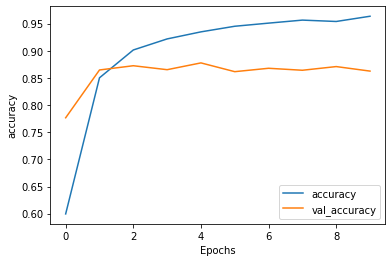

In [24]:
plot_graphs(history,'accuracy')

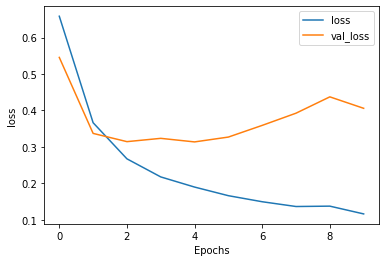

In [25]:
plot_graphs(history,'loss')

###堆叠两个或更多LSTM层
Keras循环图层有两种可用的模式，这些模式由`return_sequences`构造函数参数控制：

* 返回每个时间步的连续输出的完整序列（shape的3D张量`(batch_size, timesteps, output_features)`）。
* 仅返回每个输入序列的最后一个输出（形状为2D张量`（batch_size，output_features）`）。

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size,64),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1,activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset,epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 205ms/step - loss: 0.6845 - accuracy: 0.5391 - val_loss: 0.6137 - val_accuracy: 0.7115
Epoch 2/10
391/391 [==============================] - 75s 192ms/step - loss: 0.4212 - accuracy: 0.8272 - val_loss: 0.3678 - val_accuracy: 0.8479
Epoch 3/10
391/391 [==============================] - 74s 190ms/step - loss: 0.2782 - accuracy: 0.9000 - val_loss: 0.3167 - val_accuracy: 0.8677
Epoch 4/10
391/391 [==============================] - 76s 194ms/step - loss: 0.2294 - accuracy: 0.9248 - val_loss: 0.3196 - val_accuracy: 0.8813
Epoch 5/10
391/391 [==============================] - 78s 199ms/step - loss: 0.1928 - accuracy: 0.9398 - val_loss: 0.3440 - val_accuracy: 0.8672
Epoch 6/10
391/391 [==============================] - 79s 201ms/step - loss: 0.1705 - accuracy: 0.9501 - val_loss: 0.3648 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 78s 199ms/step - loss: 0.1435 - accuracy: 0.9596 - val_loss: 0.3922 - val_ac

In [29]:
test_loss,test_acc = model.evaluate(test_dataset)

print('Test Loss:{}'.format(test_loss))
print('Test Accuracy:{}'.format(test_acc))

    391/Unknown - 34s 87ms/step - loss: 0.5493 - accuracy: 0.8502Test Loss:0.5493102117496378
Test Accuracy:0.8501600027084351


In [30]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text,pad=False)
print(predictions)

[[0.06997122]]


In [31]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.04882305]]


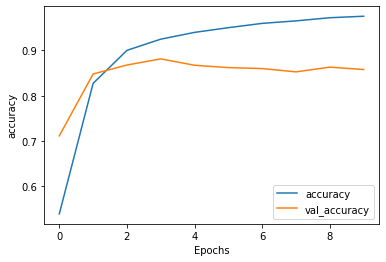

In [32]:
plot_graphs(history,'accuracy')

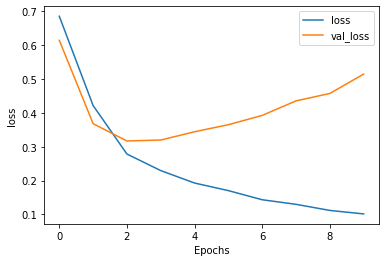

In [33]:
plot_graphs(history,'loss')

检查其他现有的循环图层，例如[GRU图层](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)。

如果您对构建自定义[RNN](https://www.tensorflow.org/guide/keras/rnn)感兴趣，请参阅《[Keras RNN指南](https://www.tensorflow.org/guide/keras/rnn)》。